In [1]:
project_name = 'wgan_face_generation'

## WGAN modified of DCGAN in:
1. remove sigmoid in the last layer of discriminator(classification -> regression)                                    
2. no log Loss (Wasserstein distance)

3. clip param norm to c (Wasserstein distance and Lipschitz continuity)

4. No momentum-based optimizer, use RMSProp，SGD instead

In [2]:
import numpy as np
import pandas as pd
import os

import torch.utils.data
from PIL import Image
from typing import Any, Tuple

from torch.utils.data import DataLoader

In [3]:
def compress_image(prev_image, n):
    if n < 2:
        return prev_image

    height = prev_image.shape[0] // n
    width = prev_image.shape[1] // n
    new_image = np.zeros((height, width), dtype="uint8")
    for i in range(0, height):
        for j in range(0, width):
            new_image[i, j] = prev_image[n * i, n * j]

    return new_image

class CEMDataset(torch.utils.data.Dataset):
    DATASETS_TRAIN = [
        'binary_501',
        'binary_502',
        'binary_503',
        'binary_504',
        'binary_505',
        'binary_506',
        'binary_507',
        'binary_508',
        'binary_509',
        'binary_510',
        'binary_511',
        'binary_512',
        'binary_1001',
        'binary_1002',
        'binary_1003',
#         'binary_rl_fix_501',
#         'binary_rl_fix_502',
#         'binary_rl_fix_503',
#         'binary_rl_fix_504',
#         'binary_rl_fix_505',
#         'binary_rl_fix_506',
#         'binary_rl_fix_507',
#         'binary_rl_fix_508',
#         'binary_rl_fix_509',
#         'binary_rl_fix_510',
#         'binary_rl_fix_511',
#         'binary_rl_fix_512',
#         'binary_rl_fix_513',
#         'binary_rl_fix_514',
#         'binary_rl_fix_515',
#         'binary_rl_fix_516',
#         'binary_rl_fix_517',
#         'binary_rl_fix_518',
#         'binary_rl_fix_519',
#         'binary_rl_fix_520',
#         'binary_rl_fix_1001',
#         'binary_rl_fix_1002',
#         'binary_rl_fix_1003',
#         'binary_rl_fix_1004',
#         'binary_rl_fix_1005',
#         'binary_rl_fix_1006',
#         'binary_rl_fix_1007',
#         'binary_rl_fix_1008',
    ]

    DATASETS_VALID = [
        'binary_1004',
        'binary_test_1001',
        'binary_test_1002',
        'binary_rl_fix_1009',
        'binary_rl_fix_1010',
        'binary_rl_fix_1011',
        'binary_rl_fix_1012',
        'binary_rl_fix_1013',
        'binary_rl_fix_test_1001',
    ]

    DATASETS_TEST = [
        'binary_new_test_501',
#         'binary_new_test_1501',
#         'binary_rl_fix_1014',
#         'binary_rl_fix_1015',
#         'binary_rl_fix_test_1002',
#         'binary_rl_fix_test_1003',
#         'binary_rl_fix_test_1004',
#         'binary_rl_fix_test_1005',
#         'binary_test_1101',
    ]

    def __init__(self,
                 root: str,
                train: bool = True,
                scale: int = 1,
        is_regression: bool = True,
                 ) -> None:
        self.train = train
        self.root = root
        self.scale = scale
        self.width = 200 // scale
        self.height = 100 // scale
        self.is_regression = is_regression

        if self.train:
            DATAPATH = os.path.join(root, 'train')
            DATASETS = self.DATASETS_TRAIN
        else:
            DATAPATH = os.path.join(root, 'test')
            DATASETS = self.DATASETS_TEST

        self.data: Any = []
        self.targets = []

        print('data loading ... ')

        # load Train dataset
        for data in DATASETS:
            dataframe = pd.read_csv(os.path.join(DATAPATH, '{}.csv'.format(data)), delim_whitespace=False, header=None)
            dataset = dataframe.values

            # split into input (X) and output (Y) variables
            fileNames = dataset[:, 0]

            # 1. first try max
            dataset[:, 1:25] /= 2767.1
            
            # 2. Classification or Regression
            labels = dataset[:, 1:25]
            if self.is_regression:
                self.targets.extend(labels)
            else:
                labels = np.apply_along_axis(lambda x: np.argmax(x), 1, labels)
                self.targets.extend(labels)
                    
            for idx, file in enumerate(fileNames):
                try:
                    image = Image.open(os.path.join(DATAPATH, data, '{}.tiff'.format(int(file))))
                    image = np.array(image).astype(np.uint8)
                except (TypeError, FileNotFoundError) as te:
                    image = Image.open(os.path.join(DATAPATH, data, '{}.tiff'.format(idx + 1)))
                    try:
                        image = np.array(image).astype(np.uint8)
                    except:
                        continue
                image = compress_image(image, self.scale)
                self.data.append(np.array(image).flatten(order='C'))

        self.data = np.vstack(self.data).reshape(-1, 1, self.height, self.width)
        self.data = self.data.transpose((0, 1, 2, 3))  # convert to HWC CHW
        print(f'Data Loading Finished. len : {len(self.data)}')


    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], self.targets[index]

        return img, target

    def __len__(self) -> int:
        return len(self.data)

In [4]:
data_dir = os.path.join(os.getcwd(), 'maxwellfdfd')
data_dir

'D:\\koreauniv\\display-ai-convergence\\maxwellfdfd'

In [5]:
# import os

# DATA_DIR = '../input/anime-faces'
# print(os.listdir(DATA_DIR))


##
# Data
# data_dir = '../maxwellfdfd'
IS_REGRESSION = True

cem_train = CEMDataset(data_dir, train=True, scale=5, is_regression = IS_REGRESSION)

data loading ... 
Data Loading Finished. len : 9000
data loading ... 
Data Loading Finished. len : 500


In [6]:
checkpoint_dir = os.path.join(os.getcwd(), 'cem', 'train', 'weights')
# checkpoint_dir = os.path.join('./cem', 'train', 'weights')
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

In [7]:
# print(os.listdir(DATA_DIR+'/data')[:10])

Let's load this dataset using the `ImageFolder` class from `torchvision`. We will also resize and crop the images to 64x64 px, and normalize the pixel values with a mean & standard deviation of 0.5 for each channel. This will ensure that pixel values are in the range `(-1, 1)`, which is more  convenient for training the discriminator. We will also create a data loader to load the data in batches.

In [8]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [9]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

#stats = (1,1,1), (1, 1, 1)

In [10]:
train_dl = DataLoader(cem_train, batch_size, shuffle=True, pin_memory=True)

Let's create helper functions to denormalize the image tensors and display some sample images from a training batch.

In [11]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
def denorm(img_tensors):
    return img_tensors * 1.

In [13]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    s = make_grid(images.detach()[:nmax], nrow=8)
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8, padding=5, pad_value=0.5).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

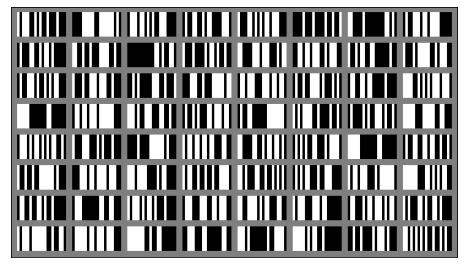

In [14]:
show_batch(train_dl)

## Using a GPU

To seamlessly use a GPU, if one is available, we define a couple of helper functions (`get_default_device` & `to_device`) and a helper class `DeviceDataLoader` to move our model & data to the GPU, if one is available.

In [15]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Based on where you're running this notebook, your default device could be a CPU (`torch.device('cpu')`) or a GPU (`torch.device('cuda')`).

In [16]:
device = get_default_device()
device

device(type='cuda')

We can now move our training data loader using `DeviceDataLoader` for automatically transferring batches of data to the GPU (if available).

In [17]:
train_dl = DeviceDataLoader(train_dl, device)

## Discriminator Network

The discriminator takes an image as input, and tries to classify it as "real" or "generated". In this sense, it's like any other neural network. We'll use a convolutional neural networks (CNN) which outputs a single number output for every image. We'll use stride of 2 to progressively reduce the size of the output feature map.

![](https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/padding_strides_odd.gif)

In [18]:
import torch.nn as nn

In [19]:
discriminator = nn.Sequential(
    # in: 1 x 20 x 40

    nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=(0, 1), bias=False),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=(3, 4), stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=(3, 4), stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    #nn.Conv2d(256, 512, kernel_size=(3, 4), stride=2, padding=1, bias=False),
    #nn.BatchNorm2d(512),
    #nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(256, 1, kernel_size=(3, 5), stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1
    
    # Modification 1: remove sigmoid
    # nn.Sigmoid()

    )
print(discriminator)

Sequential(
  (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(0, 1), bias=False)
  (1): LeakyReLU(negative_slope=0.2, inplace=True)
  (2): Conv2d(64, 128, kernel_size=(3, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): LeakyReLU(negative_slope=0.2, inplace=True)
  (5): Conv2d(128, 256, kernel_size=(3, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): LeakyReLU(negative_slope=0.2, inplace=True)
  (8): Conv2d(256, 1, kernel_size=(3, 5), stride=(1, 1), bias=False)
)


Note that we're using the Leaky ReLU activation for the discriminator.

<img src="https://cdn-images-1.medium.com/max/1600/1*ypsvQH7kvtI2BhzR2eT_Sw.png" width="420">


>  Different from the regular ReLU function, Leaky ReLU allows the pass of a small gradient signal for negative values. As a result, it makes the gradients from the discriminator flows stronger into the generator. Instead of passing a gradient (slope) of 0 in the back-prop pass, it passes a small negative gradient.  - [Source](https://sthalles.github.io/advanced_gans/)

Just like any other binary classification model, the output of the discriminator is a single number between 0 and 1, which can be interpreted as the probability of the input image being real i.e. picked from the original dataset.

Let's move the discriminator model to the chosen device.

In [20]:
discriminator = to_device(discriminator, device)

## Generator Network

The input to the generator is typically a vector or a matrix of random numbers (referred to as a latent tensor) which is used as a seed for generating an image. The generator will convert a latent tensor of shape `(128, 1, 1)` into an image tensor of shape `3 x 28 x 28`. To achive this, we'll use the `ConvTranspose2d` layer from PyTorch, which is performs to as a *transposed convolution* (also referred to as a *deconvolution*). [Learn more](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md#transposed-convolution-animations)

![](https://i.imgur.com/DRvK546.gif)

In [21]:
latent_size = 128

In [22]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 256, kernel_size=(3,5), stride=1, padding=0, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    #nn.ConvTranspose2d(512, 256, kernel_size=(3,4), stride=2, padding=1, bias=False),
    #nn.BatchNorm2d(256),
    #nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=(3,4), stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=(3,4), stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 1, kernel_size=(4,4), stride=2, padding=(0, 1), bias=False),
    nn.Tanh()
    # out: 1 x 20 x 40
)

We use the TanH activation function for the output layer of the generator.

<img src="https://nic.schraudolph.org/teach/NNcourse/figs/tanh.gif" width="420" >

> "The ReLU activation (Nair & Hinton, 2010) is used in the generator with the exception of the output layer which uses the Tanh function. We observed that using a bounded activation allowed the model to learn more quickly to saturate and cover the color space of the training distribution. Within the discriminator we found the leaky rectified activation (Maas et al., 2013) (Xu et al., 2015) to work well, especially for higher resolution modeling." - [Source](https://stackoverflow.com/questions/41489907/generative-adversarial-networks-tanh)


Note that since the outputs of the TanH activation lie in the range `[-1,1]`, we have applied the similar transformation to the images in the training dataset. Let's generate some outputs using the generator and view them as images by transforming and denormalizing the output.

In [23]:
def weight_init(m):
    # weight_initialization: important for wgan
    class_name=m.__class__.__name__
    if class_name.find('Conv')!=-1:
        m.weight.data.normal_(0,0.02)
    elif class_name.find('Norm')!=-1:
        m.weight.data.normal_(1.0,0.02)

In [24]:
discriminator.apply(weight_init)
generator.apply(weight_init)

Sequential(
  (0): ConvTranspose2d(128, 256, kernel_size=(3, 5), stride=(1, 1), bias=False)
  (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): ConvTranspose2d(256, 128, kernel_size=(3, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): ConvTranspose2d(128, 64, kernel_size=(3, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(0, 1), bias=False)
  (10): Tanh()
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([128, 1, 20, 40])


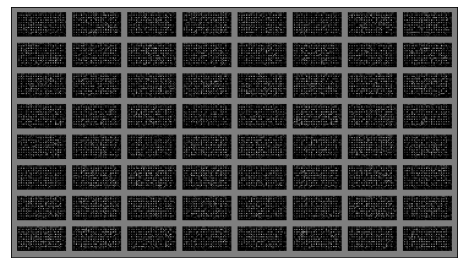

In [25]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

As one might expect, the output from the generator is basically random noise, since we haven't trained it yet. 

Let's move the generator to the chosen device.

In [26]:
generator = to_device(generator, device)

## Discriminator Training



In [27]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images.float())
    
    #modification: remove binary cross entropy
    #real_preds = real_preds.view(-1, 1)
    #real_targets = torch.ones(real_images.size(0), 1, device=device)
    #real_loss = F.binary_cross_entropy(real_preds, real_targets)

    real_loss = -torch.mean(real_preds)
        
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_preds = discriminator(fake_images)
    
    #modification: remove binary cross entropy
    #fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    #fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_loss = torch.mean(fake_preds)

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_loss.item(), fake_loss.item()

Here are the steps involved in training the discriminator.

- We expect the discriminator to output 1 if the image was picked from the real MNIST dataset, and 0 if it was generated using the generator network. 

- We first pass a batch of real images, and compute the loss, setting the target labels to 1. 

- Then we pass a batch of fake images (generated using the generator) pass them into the discriminator, and compute the loss, setting the target labels to 0. 

- Finally we add the two losses and use the overall loss to perform gradient descent to adjust the weights of the discriminator.

It's important to note that we don't change the weights of the generator model while training the discriminator (`opt_d` only affects the `discriminator.parameters()`)

## Generator Training

Since the outputs of the generator are images, it's not obvious how we can train the generator. This is where we employ a rather elegant trick, which is to use the discriminator as a part of the loss function. Here's how it works:

- We generate a batch of images using the generator, pass the into the discriminator.

- We calculate the loss by setting the target labels to 1 i.e. real. We do this because the generator's objective is to "fool" the discriminator. 

- We use the loss to perform gradient descent i.e. change the weights of the generator, so it gets better at generating real-like images to "fool" the discriminator.

Here's what this looks like in code.

In [28]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    
    
    #modificationL remove binary cross entropy
    #targets = torch.ones(batch_size, 1, device=device)
    #loss = F.binary_cross_entropy(preds, targets)
    loss = -torch.mean(preds)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

Let's create a directory where we can save intermediate outputs from the generator to visually inspect the progress of the model. We'll also create a helper function to export the generated images.

In [29]:
from torchvision.utils import save_image

In [30]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [31]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

We'll use a fixed set of input vectors to the generator to see how the individual generated images evolve over time as we train the model. Let's save one set of images before we start training our model.

In [32]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


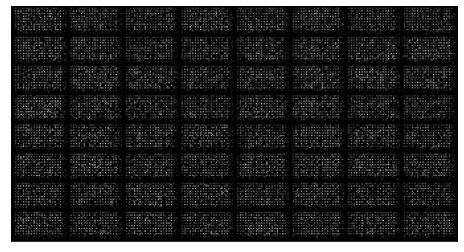

In [33]:
save_samples(0, fixed_latent)

## Full Training Loop

Let's define a `fit` function to train the discriminator and generator in tandem for each batch of training data. We'll use the Adam optimizer with some custom parameters (betas) that are known to work well for GANs. We will also save some sample generated images at regular intervals for inspection.




In [34]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [35]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.RMSprop(discriminator.parameters(), lr=lr)
    opt_g = torch.optim.RMSprop(generator.parameters(), lr=lr)
    
    
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            # modification: clip param for discriminator
            for parm in discriminator.parameters():
                parm.data.clamp_(-clamp_num, clamp_num)
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

We are now ready to train the model. Try different learning rates to see if you can maintain the fine balance between the training the generator and the discriminator.

In [36]:
lr = 0.00005
epochs = 200
clamp_num=0.01# WGAN clip gradient

In [37]:
history = fit(epochs, lr)

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [1/200], loss_g: 0.1024, loss_d: -0.1807, real_score: -0.1205, fake_score: -0.0602
Saving generated-images-0001.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [2/200], loss_g: 0.1818, loss_d: -0.2900, real_score: -0.1711, fake_score: -0.1189
Saving generated-images-0002.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [3/200], loss_g: 0.0898, loss_d: -0.3122, real_score: -0.1074, fake_score: -0.2048
Saving generated-images-0003.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [4/200], loss_g: 0.2314, loss_d: -0.3780, real_score: -0.2145, fake_score: -0.1635
Saving generated-images-0004.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [5/200], loss_g: 0.1869, loss_d: -0.3920, real_score: -0.1584, fake_score: -0.2336
Saving generated-images-0005.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [6/200], loss_g: 0.1240, loss_d: -0.3694, real_score: -0.1295, fake_score: -0.2399
Saving generated-images-0006.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [7/200], loss_g: 0.2115, loss_d: -0.4143, real_score: -0.1809, fake_score: -0.2333
Saving generated-images-0007.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [8/200], loss_g: 0.2491, loss_d: -0.4062, real_score: -0.2054, fake_score: -0.2008
Saving generated-images-0008.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [9/200], loss_g: 0.2239, loss_d: -0.3896, real_score: -0.1892, fake_score: -0.2004
Saving generated-images-0009.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [10/200], loss_g: 0.1442, loss_d: -0.3400, real_score: -0.0927, fake_score: -0.2474
Saving generated-images-0010.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [11/200], loss_g: 0.2309, loss_d: -0.3765, real_score: -0.2027, fake_score: -0.1738
Saving generated-images-0011.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [12/200], loss_g: 0.1545, loss_d: -0.3571, real_score: -0.1371, fake_score: -0.2199
Saving generated-images-0012.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [13/200], loss_g: 0.2137, loss_d: -0.3112, real_score: -0.2067, fake_score: -0.1045
Saving generated-images-0013.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [14/200], loss_g: 0.0891, loss_d: -0.2805, real_score: -0.0901, fake_score: -0.1904
Saving generated-images-0014.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [15/200], loss_g: 0.1930, loss_d: -0.2813, real_score: -0.1795, fake_score: -0.1018
Saving generated-images-0015.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [16/200], loss_g: 0.0927, loss_d: -0.2881, real_score: -0.1040, fake_score: -0.1841
Saving generated-images-0016.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [17/200], loss_g: 0.1880, loss_d: -0.2496, real_score: -0.1909, fake_score: -0.0588
Saving generated-images-0017.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [18/200], loss_g: 0.0793, loss_d: -0.2675, real_score: -0.0968, fake_score: -0.1707
Saving generated-images-0018.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [19/200], loss_g: 0.1855, loss_d: -0.2634, real_score: -0.1792, fake_score: -0.0842
Saving generated-images-0019.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [20/200], loss_g: 0.0151, loss_d: -0.2512, real_score: -0.0753, fake_score: -0.1758
Saving generated-images-0020.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [21/200], loss_g: 0.1702, loss_d: -0.2078, real_score: -0.1883, fake_score: -0.0195
Saving generated-images-0021.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [22/200], loss_g: 0.0338, loss_d: -0.2545, real_score: -0.0755, fake_score: -0.1789
Saving generated-images-0022.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [23/200], loss_g: 0.1705, loss_d: -0.2233, real_score: -0.1746, fake_score: -0.0487
Saving generated-images-0023.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [24/200], loss_g: 0.0000, loss_d: -0.2183, real_score: -0.0469, fake_score: -0.1714
Saving generated-images-0024.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [25/200], loss_g: 0.1634, loss_d: -0.2059, real_score: -0.1728, fake_score: -0.0331
Saving generated-images-0025.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [26/200], loss_g: 0.0310, loss_d: -0.2065, real_score: -0.0532, fake_score: -0.1533
Saving generated-images-0026.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [27/200], loss_g: 0.1690, loss_d: -0.1948, real_score: -0.1775, fake_score: -0.0172
Saving generated-images-0027.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [28/200], loss_g: 0.0107, loss_d: -0.1971, real_score: -0.0435, fake_score: -0.1536
Saving generated-images-0028.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [29/200], loss_g: 0.1488, loss_d: -0.1998, real_score: -0.1762, fake_score: -0.0236
Saving generated-images-0029.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [30/200], loss_g: -0.0032, loss_d: -0.1871, real_score: -0.0403, fake_score: -0.1468
Saving generated-images-0030.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [31/200], loss_g: 0.1501, loss_d: -0.1599, real_score: -0.1787, fake_score: 0.0188
Saving generated-images-0031.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [32/200], loss_g: -0.0115, loss_d: -0.1781, real_score: -0.0345, fake_score: -0.1436
Saving generated-images-0032.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [33/200], loss_g: 0.1452, loss_d: -0.1563, real_score: -0.1799, fake_score: 0.0236
Saving generated-images-0033.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [34/200], loss_g: -0.0008, loss_d: -0.1949, real_score: -0.0485, fake_score: -0.1464
Saving generated-images-0034.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [35/200], loss_g: 0.1480, loss_d: -0.1651, real_score: -0.1808, fake_score: 0.0157
Saving generated-images-0035.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [36/200], loss_g: -0.0285, loss_d: -0.1981, real_score: -0.0542, fake_score: -0.1440
Saving generated-images-0036.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [37/200], loss_g: 0.1460, loss_d: -0.1953, real_score: -0.1490, fake_score: -0.0463
Saving generated-images-0037.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [38/200], loss_g: 0.0003, loss_d: -0.1882, real_score: -0.0446, fake_score: -0.1436
Saving generated-images-0038.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [39/200], loss_g: 0.1334, loss_d: -0.1693, real_score: -0.1889, fake_score: 0.0197
Saving generated-images-0039.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [40/200], loss_g: -0.0541, loss_d: -0.1855, real_score: -0.0505, fake_score: -0.1350
Saving generated-images-0040.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [41/200], loss_g: -0.0343, loss_d: -0.1816, real_score: -0.0435, fake_score: -0.1382
Saving generated-images-0041.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [42/200], loss_g: 0.1297, loss_d: -0.1693, real_score: -0.1839, fake_score: 0.0146
Saving generated-images-0042.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [43/200], loss_g: 0.0400, loss_d: -0.1913, real_score: -0.0777, fake_score: -0.1137
Saving generated-images-0043.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [44/200], loss_g: 0.1426, loss_d: -0.1495, real_score: -0.1772, fake_score: 0.0277
Saving generated-images-0044.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [45/200], loss_g: -0.0043, loss_d: -0.1837, real_score: -0.0549, fake_score: -0.1289
Saving generated-images-0045.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [46/200], loss_g: -0.0322, loss_d: -0.1707, real_score: -0.0342, fake_score: -0.1366
Saving generated-images-0046.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [47/200], loss_g: 0.1043, loss_d: -0.1929, real_score: -0.1416, fake_score: -0.0513
Saving generated-images-0047.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [48/200], loss_g: -0.0128, loss_d: -0.1730, real_score: -0.0561, fake_score: -0.1169
Saving generated-images-0048.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [49/200], loss_g: 0.1273, loss_d: -0.1862, real_score: -0.1456, fake_score: -0.0405
Saving generated-images-0049.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [50/200], loss_g: -0.0764, loss_d: -0.1921, real_score: -0.0523, fake_score: -0.1398
Saving generated-images-0050.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [51/200], loss_g: 0.1388, loss_d: -0.1618, real_score: -0.1795, fake_score: 0.0178
Saving generated-images-0051.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [52/200], loss_g: -0.0679, loss_d: -0.1682, real_score: -0.0404, fake_score: -0.1278
Saving generated-images-0052.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [53/200], loss_g: 0.1107, loss_d: -0.1632, real_score: -0.1376, fake_score: -0.0256
Saving generated-images-0053.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [54/200], loss_g: -0.0530, loss_d: -0.1895, real_score: -0.0647, fake_score: -0.1248
Saving generated-images-0054.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [55/200], loss_g: 0.1153, loss_d: -0.1390, real_score: -0.1828, fake_score: 0.0438
Saving generated-images-0055.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [56/200], loss_g: -0.0266, loss_d: -0.1880, real_score: -0.0556, fake_score: -0.1323
Saving generated-images-0056.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [57/200], loss_g: 0.1388, loss_d: -0.1731, real_score: -0.1772, fake_score: 0.0041
Saving generated-images-0057.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [58/200], loss_g: -0.0254, loss_d: -0.1712, real_score: -0.0521, fake_score: -0.1190
Saving generated-images-0058.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [59/200], loss_g: 0.1192, loss_d: -0.1543, real_score: -0.1878, fake_score: 0.0335
Saving generated-images-0059.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [60/200], loss_g: 0.0950, loss_d: -0.1223, real_score: -0.1852, fake_score: 0.0630
Saving generated-images-0060.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [61/200], loss_g: 0.1163, loss_d: -0.1439, real_score: -0.1727, fake_score: 0.0287
Saving generated-images-0061.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [62/200], loss_g: -0.0579, loss_d: -0.1795, real_score: -0.0534, fake_score: -0.1261
Saving generated-images-0062.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [63/200], loss_g: 0.1329, loss_d: -0.1583, real_score: -0.1697, fake_score: 0.0114
Saving generated-images-0063.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [64/200], loss_g: 0.1379, loss_d: -0.1615, real_score: -0.1520, fake_score: -0.0095
Saving generated-images-0064.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [65/200], loss_g: -0.0628, loss_d: -0.1651, real_score: -0.0467, fake_score: -0.1184
Saving generated-images-0065.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [66/200], loss_g: 0.1286, loss_d: -0.1607, real_score: -0.1618, fake_score: 0.0011
Saving generated-images-0066.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [67/200], loss_g: 0.0441, loss_d: -0.1745, real_score: -0.0741, fake_score: -0.1004
Saving generated-images-0067.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [68/200], loss_g: 0.0069, loss_d: -0.1607, real_score: -0.0579, fake_score: -0.1027
Saving generated-images-0068.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [69/200], loss_g: -0.0213, loss_d: -0.1557, real_score: -0.0313, fake_score: -0.1243
Saving generated-images-0069.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [70/200], loss_g: 0.1201, loss_d: -0.1518, real_score: -0.1503, fake_score: -0.0015
Saving generated-images-0070.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [71/200], loss_g: 0.1299, loss_d: -0.1416, real_score: -0.1562, fake_score: 0.0145
Saving generated-images-0071.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [72/200], loss_g: -0.0252, loss_d: -0.1509, real_score: -0.0395, fake_score: -0.1114
Saving generated-images-0072.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [73/200], loss_g: 0.0544, loss_d: -0.1559, real_score: -0.0877, fake_score: -0.0683
Saving generated-images-0073.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [74/200], loss_g: 0.1006, loss_d: -0.1657, real_score: -0.1338, fake_score: -0.0319
Saving generated-images-0074.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [75/200], loss_g: -0.0585, loss_d: -0.1344, real_score: -0.0050, fake_score: -0.1294
Saving generated-images-0075.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [76/200], loss_g: 0.0990, loss_d: -0.1374, real_score: -0.1374, fake_score: 0.0000
Saving generated-images-0076.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [77/200], loss_g: 0.0130, loss_d: -0.1697, real_score: -0.0657, fake_score: -0.1039
Saving generated-images-0077.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [78/200], loss_g: 0.1228, loss_d: -0.1429, real_score: -0.1809, fake_score: 0.0380
Saving generated-images-0078.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [79/200], loss_g: -0.0454, loss_d: -0.1078, real_score: 0.0288, fake_score: -0.1366
Saving generated-images-0079.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [80/200], loss_g: 0.1006, loss_d: -0.1746, real_score: -0.1181, fake_score: -0.0566
Saving generated-images-0080.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [81/200], loss_g: -0.0354, loss_d: -0.1747, real_score: -0.0467, fake_score: -0.1280
Saving generated-images-0081.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [82/200], loss_g: 0.0053, loss_d: -0.1966, real_score: -0.0843, fake_score: -0.1122
Saving generated-images-0082.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [83/200], loss_g: 0.1070, loss_d: -0.1620, real_score: -0.1436, fake_score: -0.0184
Saving generated-images-0083.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [84/200], loss_g: 0.0260, loss_d: -0.1292, real_score: -0.0250, fake_score: -0.1043
Saving generated-images-0084.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [85/200], loss_g: 0.1339, loss_d: -0.1576, real_score: -0.1660, fake_score: 0.0084
Saving generated-images-0085.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [86/200], loss_g: 0.0312, loss_d: -0.2016, real_score: -0.0799, fake_score: -0.1217
Saving generated-images-0086.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [87/200], loss_g: -0.0144, loss_d: -0.1226, real_score: 0.0082, fake_score: -0.1308
Saving generated-images-0087.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [88/200], loss_g: -0.0209, loss_d: -0.1640, real_score: -0.0341, fake_score: -0.1299
Saving generated-images-0088.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [89/200], loss_g: 0.1513, loss_d: -0.1992, real_score: -0.1431, fake_score: -0.0561
Saving generated-images-0089.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [90/200], loss_g: 0.1300, loss_d: -0.1585, real_score: -0.1588, fake_score: 0.0003
Saving generated-images-0090.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [91/200], loss_g: 0.0310, loss_d: -0.1480, real_score: -0.0475, fake_score: -0.1006
Saving generated-images-0091.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [92/200], loss_g: 0.1476, loss_d: -0.1551, real_score: -0.1673, fake_score: 0.0122
Saving generated-images-0092.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [93/200], loss_g: -0.0363, loss_d: -0.1414, real_score: -0.0078, fake_score: -0.1336
Saving generated-images-0093.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [94/200], loss_g: 0.1343, loss_d: -0.1512, real_score: -0.1716, fake_score: 0.0204
Saving generated-images-0094.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [95/200], loss_g: 0.0514, loss_d: -0.1971, real_score: -0.0795, fake_score: -0.1176
Saving generated-images-0095.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [96/200], loss_g: 0.1136, loss_d: -0.1325, real_score: -0.1497, fake_score: 0.0172
Saving generated-images-0096.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [97/200], loss_g: -0.0361, loss_d: -0.1700, real_score: -0.0431, fake_score: -0.1270
Saving generated-images-0097.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [98/200], loss_g: 0.1683, loss_d: -0.1551, real_score: -0.2024, fake_score: 0.0473
Saving generated-images-0098.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [99/200], loss_g: -0.0292, loss_d: -0.1820, real_score: -0.0364, fake_score: -0.1456
Saving generated-images-0099.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [100/200], loss_g: 0.1279, loss_d: -0.1449, real_score: -0.1570, fake_score: 0.0121
Saving generated-images-0100.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [101/200], loss_g: 0.0592, loss_d: -0.1430, real_score: -0.0549, fake_score: -0.0881
Saving generated-images-0101.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [102/200], loss_g: -0.0184, loss_d: -0.1891, real_score: -0.0581, fake_score: -0.1310
Saving generated-images-0102.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [103/200], loss_g: 0.1729, loss_d: -0.1795, real_score: -0.1812, fake_score: 0.0017
Saving generated-images-0103.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [104/200], loss_g: -0.0287, loss_d: -0.1338, real_score: 0.0067, fake_score: -0.1405
Saving generated-images-0104.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [105/200], loss_g: 0.1113, loss_d: -0.1319, real_score: -0.1364, fake_score: 0.0045
Saving generated-images-0105.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [106/200], loss_g: -0.0155, loss_d: -0.1270, real_score: -0.0071, fake_score: -0.1198
Saving generated-images-0106.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [107/200], loss_g: 0.1476, loss_d: -0.1670, real_score: -0.1620, fake_score: -0.0050
Saving generated-images-0107.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [108/200], loss_g: 0.1071, loss_d: -0.1915, real_score: -0.1093, fake_score: -0.0823
Saving generated-images-0108.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [109/200], loss_g: -0.0176, loss_d: -0.1180, real_score: 0.0165, fake_score: -0.1345
Saving generated-images-0109.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [110/200], loss_g: 0.1270, loss_d: -0.1350, real_score: -0.1605, fake_score: 0.0255
Saving generated-images-0110.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [111/200], loss_g: -0.0163, loss_d: -0.1023, real_score: 0.0292, fake_score: -0.1314
Saving generated-images-0111.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [112/200], loss_g: 0.1752, loss_d: -0.1928, real_score: -0.1563, fake_score: -0.0365
Saving generated-images-0112.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [113/200], loss_g: 0.0166, loss_d: -0.1281, real_score: -0.0000, fake_score: -0.1281
Saving generated-images-0113.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [114/200], loss_g: -0.0137, loss_d: -0.1825, real_score: -0.0420, fake_score: -0.1406
Saving generated-images-0114.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [115/200], loss_g: 0.2084, loss_d: -0.2081, real_score: -0.2012, fake_score: -0.0069
Saving generated-images-0115.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [116/200], loss_g: 0.0502, loss_d: -0.1629, real_score: -0.0801, fake_score: -0.0828
Saving generated-images-0116.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [117/200], loss_g: 0.0944, loss_d: -0.1454, real_score: -0.1240, fake_score: -0.0214
Saving generated-images-0117.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [118/200], loss_g: 0.0345, loss_d: -0.1481, real_score: -0.0437, fake_score: -0.1044
Saving generated-images-0118.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [119/200], loss_g: 0.0008, loss_d: -0.1640, real_score: -0.0194, fake_score: -0.1446
Saving generated-images-0119.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [120/200], loss_g: 0.1612, loss_d: -0.2060, real_score: -0.1429, fake_score: -0.0631
Saving generated-images-0120.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [121/200], loss_g: 0.1405, loss_d: -0.2168, real_score: -0.1399, fake_score: -0.0769
Saving generated-images-0121.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [122/200], loss_g: -0.0047, loss_d: -0.1758, real_score: -0.0494, fake_score: -0.1264
Saving generated-images-0122.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [123/200], loss_g: 0.1105, loss_d: -0.1363, real_score: -0.1175, fake_score: -0.0188
Saving generated-images-0123.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [124/200], loss_g: 0.0604, loss_d: -0.1912, real_score: -0.0873, fake_score: -0.1038
Saving generated-images-0124.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [125/200], loss_g: -0.0420, loss_d: -0.1893, real_score: -0.0281, fake_score: -0.1611
Saving generated-images-0125.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [126/200], loss_g: 0.0185, loss_d: -0.1679, real_score: -0.0790, fake_score: -0.0889
Saving generated-images-0126.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [127/200], loss_g: 0.0824, loss_d: -0.1307, real_score: -0.1415, fake_score: 0.0108
Saving generated-images-0127.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [128/200], loss_g: -0.0065, loss_d: -0.1156, real_score: 0.0359, fake_score: -0.1514
Saving generated-images-0128.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [129/200], loss_g: 0.0155, loss_d: -0.1201, real_score: 0.0103, fake_score: -0.1304
Saving generated-images-0129.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [130/200], loss_g: 0.1787, loss_d: -0.2036, real_score: -0.1627, fake_score: -0.0409
Saving generated-images-0130.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [131/200], loss_g: 0.0092, loss_d: -0.1808, real_score: -0.0662, fake_score: -0.1146
Saving generated-images-0131.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [132/200], loss_g: 0.1468, loss_d: -0.1628, real_score: -0.1589, fake_score: -0.0039
Saving generated-images-0132.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [133/200], loss_g: 0.1574, loss_d: -0.1605, real_score: -0.1647, fake_score: 0.0043
Saving generated-images-0133.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [134/200], loss_g: 0.1079, loss_d: -0.2042, real_score: -0.1110, fake_score: -0.0931
Saving generated-images-0134.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [135/200], loss_g: -0.0454, loss_d: -0.2098, real_score: -0.0655, fake_score: -0.1443
Saving generated-images-0135.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [136/200], loss_g: 0.1318, loss_d: -0.1607, real_score: -0.1227, fake_score: -0.0380
Saving generated-images-0136.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [137/200], loss_g: -0.0168, loss_d: -0.1215, real_score: 0.0470, fake_score: -0.1684
Saving generated-images-0137.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [138/200], loss_g: 0.1360, loss_d: -0.2012, real_score: -0.1265, fake_score: -0.0747
Saving generated-images-0138.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [139/200], loss_g: 0.1296, loss_d: -0.1637, real_score: -0.1399, fake_score: -0.0237
Saving generated-images-0139.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [140/200], loss_g: 0.1213, loss_d: -0.1627, real_score: -0.1135, fake_score: -0.0492
Saving generated-images-0140.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [141/200], loss_g: -0.0585, loss_d: -0.1732, real_score: -0.0030, fake_score: -0.1702
Saving generated-images-0141.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [142/200], loss_g: -0.0186, loss_d: -0.1607, real_score: 0.0006, fake_score: -0.1612
Saving generated-images-0142.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [143/200], loss_g: 0.0295, loss_d: -0.1914, real_score: -0.0522, fake_score: -0.1392
Saving generated-images-0143.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [144/200], loss_g: -0.0166, loss_d: -0.1806, real_score: -0.0434, fake_score: -0.1372
Saving generated-images-0144.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [145/200], loss_g: -0.0057, loss_d: -0.1589, real_score: -0.0054, fake_score: -0.1535
Saving generated-images-0145.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [146/200], loss_g: 0.1555, loss_d: -0.1612, real_score: -0.1723, fake_score: 0.0111
Saving generated-images-0146.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [147/200], loss_g: 0.1379, loss_d: -0.1984, real_score: -0.1365, fake_score: -0.0619
Saving generated-images-0147.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [148/200], loss_g: 0.0259, loss_d: -0.1180, real_score: 0.0040, fake_score: -0.1220
Saving generated-images-0148.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [149/200], loss_g: 0.0464, loss_d: -0.1989, real_score: -0.0830, fake_score: -0.1159
Saving generated-images-0149.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [150/200], loss_g: 0.1335, loss_d: -0.1467, real_score: -0.1553, fake_score: 0.0086
Saving generated-images-0150.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [151/200], loss_g: 0.1306, loss_d: -0.1430, real_score: -0.1134, fake_score: -0.0296
Saving generated-images-0151.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [152/200], loss_g: -0.0447, loss_d: -0.1653, real_score: -0.0135, fake_score: -0.1518
Saving generated-images-0152.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [153/200], loss_g: 0.1099, loss_d: -0.1662, real_score: -0.1265, fake_score: -0.0397
Saving generated-images-0153.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [154/200], loss_g: -0.0195, loss_d: -0.1437, real_score: -0.0041, fake_score: -0.1396
Saving generated-images-0154.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [155/200], loss_g: 0.1437, loss_d: -0.1586, real_score: -0.1434, fake_score: -0.0152
Saving generated-images-0155.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [156/200], loss_g: 0.0322, loss_d: -0.1370, real_score: -0.0313, fake_score: -0.1057
Saving generated-images-0156.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [157/200], loss_g: -0.0610, loss_d: -0.1115, real_score: 0.0310, fake_score: -0.1426
Saving generated-images-0157.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [158/200], loss_g: 0.1550, loss_d: -0.1487, real_score: -0.1649, fake_score: 0.0162
Saving generated-images-0158.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [159/200], loss_g: -0.0261, loss_d: -0.1302, real_score: -0.0148, fake_score: -0.1154
Saving generated-images-0159.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [160/200], loss_g: 0.0848, loss_d: -0.1401, real_score: -0.0949, fake_score: -0.0452
Saving generated-images-0160.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [161/200], loss_g: 0.0294, loss_d: -0.1408, real_score: -0.0497, fake_score: -0.0911
Saving generated-images-0161.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [162/200], loss_g: 0.1097, loss_d: -0.1006, real_score: -0.1569, fake_score: 0.0563
Saving generated-images-0162.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [163/200], loss_g: 0.0667, loss_d: -0.1437, real_score: -0.0705, fake_score: -0.0731
Saving generated-images-0163.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [164/200], loss_g: -0.0322, loss_d: -0.1044, real_score: 0.0111, fake_score: -0.1155
Saving generated-images-0164.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [165/200], loss_g: 0.1486, loss_d: -0.1410, real_score: -0.1606, fake_score: 0.0196
Saving generated-images-0165.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [166/200], loss_g: 0.1396, loss_d: -0.1307, real_score: -0.1370, fake_score: 0.0063
Saving generated-images-0166.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [167/200], loss_g: -0.0208, loss_d: -0.1174, real_score: -0.0063, fake_score: -0.1112
Saving generated-images-0167.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [168/200], loss_g: 0.1116, loss_d: -0.1120, real_score: -0.1370, fake_score: 0.0250
Saving generated-images-0168.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [169/200], loss_g: -0.0346, loss_d: -0.1302, real_score: -0.0582, fake_score: -0.0719
Saving generated-images-0169.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [170/200], loss_g: 0.0662, loss_d: -0.1194, real_score: -0.0860, fake_score: -0.0334
Saving generated-images-0170.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [171/200], loss_g: 0.0051, loss_d: -0.1187, real_score: -0.0096, fake_score: -0.1091
Saving generated-images-0171.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [172/200], loss_g: 0.1233, loss_d: -0.1202, real_score: -0.1212, fake_score: 0.0010
Saving generated-images-0172.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [173/200], loss_g: -0.0542, loss_d: -0.1437, real_score: -0.0373, fake_score: -0.1065
Saving generated-images-0173.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [174/200], loss_g: 0.0999, loss_d: -0.0950, real_score: -0.1250, fake_score: 0.0300
Saving generated-images-0174.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [175/200], loss_g: -0.0337, loss_d: -0.1235, real_score: -0.0178, fake_score: -0.1056
Saving generated-images-0175.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [176/200], loss_g: 0.1106, loss_d: -0.1013, real_score: -0.1391, fake_score: 0.0378
Saving generated-images-0176.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [177/200], loss_g: 0.0785, loss_d: -0.1124, real_score: -0.1097, fake_score: -0.0027
Saving generated-images-0177.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [178/200], loss_g: -0.0386, loss_d: -0.1351, real_score: -0.0332, fake_score: -0.1019
Saving generated-images-0178.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [179/200], loss_g: 0.0084, loss_d: -0.1081, real_score: -0.0175, fake_score: -0.0906
Saving generated-images-0179.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [180/200], loss_g: 0.1168, loss_d: -0.1214, real_score: -0.1036, fake_score: -0.0178
Saving generated-images-0180.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [181/200], loss_g: -0.1066, loss_d: -0.1355, real_score: -0.0096, fake_score: -0.1260
Saving generated-images-0181.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [182/200], loss_g: 0.0358, loss_d: -0.0987, real_score: -0.0392, fake_score: -0.0594
Saving generated-images-0182.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [183/200], loss_g: -0.0255, loss_d: -0.0950, real_score: 0.0008, fake_score: -0.0958
Saving generated-images-0183.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [184/200], loss_g: 0.0901, loss_d: -0.1217, real_score: -0.1039, fake_score: -0.0178
Saving generated-images-0184.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [185/200], loss_g: 0.0274, loss_d: -0.1197, real_score: -0.0463, fake_score: -0.0734
Saving generated-images-0185.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [186/200], loss_g: 0.1223, loss_d: -0.1460, real_score: -0.1439, fake_score: -0.0021
Saving generated-images-0186.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [187/200], loss_g: -0.0160, loss_d: -0.1047, real_score: 0.0070, fake_score: -0.1118
Saving generated-images-0187.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [188/200], loss_g: -0.0510, loss_d: -0.1155, real_score: 0.0029, fake_score: -0.1184
Saving generated-images-0188.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [189/200], loss_g: 0.0753, loss_d: -0.1227, real_score: -0.1019, fake_score: -0.0208
Saving generated-images-0189.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [190/200], loss_g: -0.0147, loss_d: -0.1180, real_score: -0.0023, fake_score: -0.1157
Saving generated-images-0190.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [191/200], loss_g: 0.1093, loss_d: -0.1081, real_score: -0.1428, fake_score: 0.0347
Saving generated-images-0191.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [192/200], loss_g: 0.1634, loss_d: -0.1604, real_score: -0.1434, fake_score: -0.0170
Saving generated-images-0192.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [193/200], loss_g: 0.0900, loss_d: -0.0933, real_score: -0.0848, fake_score: -0.0085
Saving generated-images-0193.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [194/200], loss_g: 0.0080, loss_d: -0.1146, real_score: -0.0326, fake_score: -0.0820
Saving generated-images-0194.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [195/200], loss_g: 0.0874, loss_d: -0.1111, real_score: -0.1140, fake_score: 0.0029
Saving generated-images-0195.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [196/200], loss_g: 0.1069, loss_d: -0.1082, real_score: -0.1250, fake_score: 0.0168
Saving generated-images-0196.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [197/200], loss_g: -0.0222, loss_d: -0.1279, real_score: -0.0195, fake_score: -0.1084
Saving generated-images-0197.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [198/200], loss_g: 0.0906, loss_d: -0.1305, real_score: -0.1064, fake_score: -0.0241
Saving generated-images-0198.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [199/200], loss_g: -0.0046, loss_d: -0.1000, real_score: 0.0024, fake_score: -0.1025
Saving generated-images-0199.png


  0%|          | 0/71 [00:00<?, ?it/s]

Epoch [200/200], loss_g: -0.0326, loss_d: -0.0985, real_score: 0.0032, fake_score: -0.1017
Saving generated-images-0200.png


In [38]:
losses_g, losses_d, real_scores, fake_scores = history

Now that we have trained the models, we can save checkpoints.

In [39]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

Here's how the generated images look, after the 1st, 5th and 10th epochs of training.

In [40]:
from IPython.display import Image

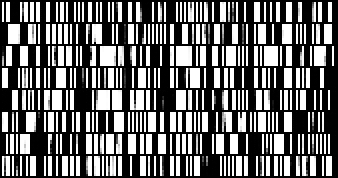

In [41]:
Image('./generated/generated-images-0199.png')

We can visualize the training process by combining the sample images generated after each epoch into a video using OpenCV.

In [46]:
import cv2
import os
import imageio

vid_fname = 'gans_training.gif'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

images = []
for filename in files:
    images.append(imageio.imread(filename))
imageio.mimsave(vid_fname, images)


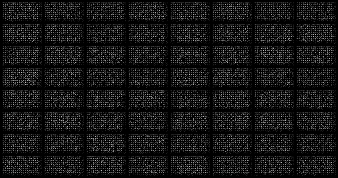

In [47]:
Image('./gans_training.gif')

Here's what it looks like:

![]()


We can also visualize how the loss changes over time. Visualizing 
losses is quite useful for debugging the training process. For GANs, we expect the generator's loss to reduce over time, without the discriminator's loss getting too high.



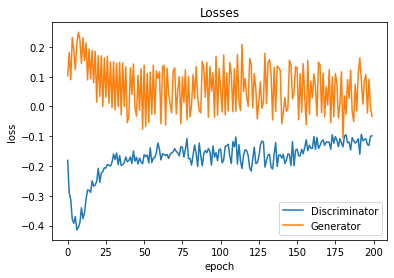

In [43]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

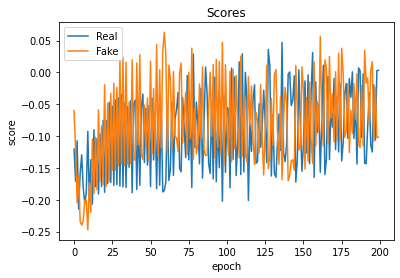

In [44]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');